In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

# import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
# tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.enable_checks = True

jax.devices()

[gpu(id=0)]

# Payoff

In [2]:
class EuropeanPayoff:

    # TODO: naming: strike_prices should be strike_price unless we would like to support an array of strike prices
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

# Smoothing

## test sequence

31.60696125855624


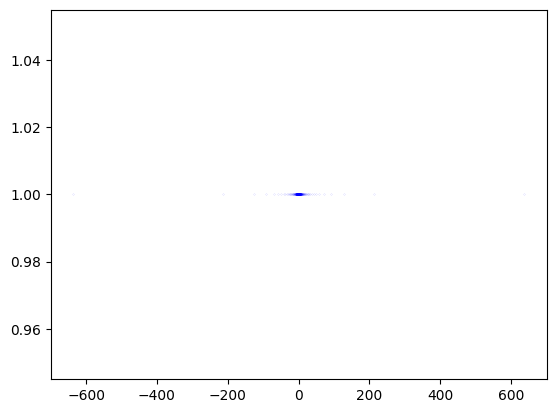

In [3]:
def chebyshev_sequence(n):
    # Generate Chebyshev nodes in the interval [-1, 1]
    k = np.arange(1, n + 1)
    nodes = np.tan((2 * k - 1) * np.pi / (2 * n))
    return nodes

# Number of points in the sequence
n = 1000  # Adjust as needed

# Generate the Chebyshev sequence
sequence = chebyshev_sequence(n)
print(jnp.std(sequence))
plt.plot(sequence, jnp.ones(n), 'b.', markersize=0.1)
plt.show()

In [4]:

def plot_smoothing(xs, ys, dys):
    plt.plot(xs, ys, 'b.', markersize=1.0, label="values")
    plt.plot(xs, dys, 'r.', markersize=1.0, label="grads")
    plt.legend()
    plt.xlim([-1e0, 1e0])
    plt.ylim([-0.1, 1])
    plt.show()

## sigmoidal smoothing

0.001001001001001034


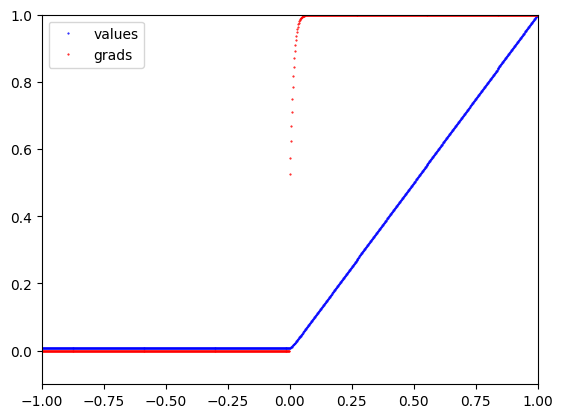

In [13]:
jax.clear_caches()
def sigmoidal_smoothing(f, k=100.0):

    def smooth_f(*args):
        return 1.0/k * jnp.log(1.0 + jnp.exp(k * f(*args)))

    return smooth_f

smooth_max = sigmoidal_smoothing(lambda x: jnp.maximum(0.0, x))

# xs = sequence
xs = jnp.linspace(-1, 1, 1000)
print(jnp.min(jnp.abs(xs)))
ys_true = jnp.maximum(0.0, xs)
# print("xs", xs)
# print("ys_true", ys_true)

ys, dys = jax.vmap(jax.value_and_grad(smooth_max))(xs)
plot_smoothing(xs, ys, dys)


## cubic spline smoothing

ys_error 9.375e-05


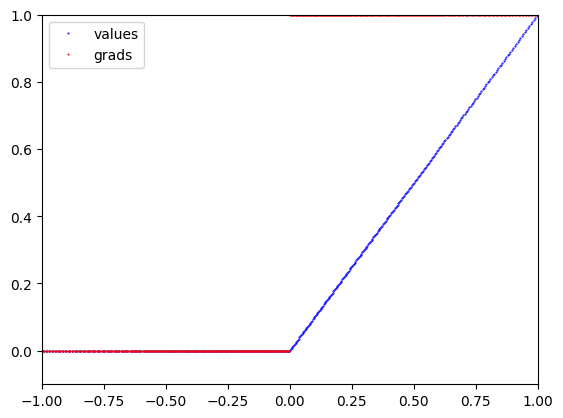

In [ ]:
# cubic spline smoothing from:
# https://link.springer.com/article/10.1007/s00780-009-0097-9

def cubic_spline_smoothing(f, k=1e-3):
    @jit
    def smooth_f(*args):
        x = f(*args)
        i = jnp.argwhere(jnp.array([x < -k, x <= k, True]), size=1).squeeze()
        below = lambda x: jnp.zeros_like(x)
        poly = lambda x: -1/(16*(k**3)) * x**4 + 3/(8*k) * x**2 + .5*x + (3*k)/16
        above = lambda x: x
        return jax.lax.switch(i, [below, poly, above], x)

    return smooth_f

smooth_max_cubic = cubic_spline_smoothing(partial(jnp.maximum, 0.0))

xs = sequence
ys_true = jnp.maximum(0.0, xs)
ys, dys = jax.vmap(jax.value_and_grad(smooth_max_cubic))(xs)

print("ys_error", jnp.mean(ys-ys_true))
plot_smoothing(xs, ys, dys)


euro_payoff = partial(EuropeanPayoff.call, strike_prices=.2)
euro_smooth = cubic_spline_smoothing(euro_payoff)
ys_true = euro_payoff(xs)
ys, dys = vmap(jax.value_and_grad(euro_smooth))(xs)
print("ys_error", jnp.mean(ys-ys_true))
plot_smoothing(xs, ys, dys)


# Checkpointing of scan

In [74]:
# Copyright 2022 Google LLC.
# SPDX-License-Identifier: Apache-2.0
# from: https://github.com/google/jax/issues/2139#issuecomment-1189382794
import math
import typing
from typing import Any, Callable, Optional, Sequence, Tuple, TypeVar, Union

import jax
import jax.numpy as jnp


Carry = TypeVar('Carry')
Input = TypeVar('Input')
Output = TypeVar('Output')
Func = TypeVar('Func', bound=Callable)


def nested_checkpoint_scan(
    f: Callable[[Carry, Input], Tuple[Carry, Output]],
    init: Carry,
    xs: Input,
    length: Optional[int] = None,
    *,
    nested_lengths: Sequence[int],
    scan_fn = jax.lax.scan,
    checkpoint_fn: Callable[[Func], Func] = jax.checkpoint,
) -> Tuple[Carry, Output]:
  """A version of lax.scan that supports recursive gradient checkpointing.

  The interface of `nested_checkpoint_scan` exactly matches lax.scan, except for
  the required `nested_lengths` argument.

  The key feature of `nested_checkpoint_scan` is that gradient calculations
  require O(max(nested_lengths)) memory, vs O(prod(nested_lengths)) for unnested
  scans, which it achieves by re-evaluating the forward pass
  `len(nested_lengths) - 1` times.

  `nested_checkpoint_scan` reduces to `lax.scan` when `nested_lengths` has a
  single element.

  Args:
    f: function to scan over.
    init: initial value.
    xs: scanned over values.
    length: leading length of all dimensions
    nested_lengths: required list of lengths to scan over for each level of
      checkpointing. The product of nested_lengths must match length (if
      provided) and the size of the leading axis for all arrays in ``xs``.
    scan_fn: function matching the API of lax.scan
    checkpoint_fn: function matching the API of jax.checkpoint.

  Returns:
    Carry and output values.
  """
  if length is not None and length != math.prod(nested_lengths):
    raise ValueError(f'inconsistent {length=} and {nested_lengths=}')

  def nested_reshape(x):
    x = jnp.asarray(x)
    new_shape = tuple(nested_lengths) + x.shape[1:]
    return x.reshape(new_shape)

  sub_xs = jax.tree_map(nested_reshape, xs)
  return _inner_nested_scan(f, init, sub_xs, nested_lengths, scan_fn,
                            checkpoint_fn)


def _inner_nested_scan(f, init, xs, lengths, scan_fn, checkpoint_fn):
  """Recursively applied scan function."""
  if len(lengths) == 1:
    return scan_fn(f, init, xs, lengths[0])

  @checkpoint_fn
  def sub_scans(carry, xs):
    return _inner_nested_scan(f, carry, xs, lengths[1:], scan_fn, checkpoint_fn)

  carry, out = scan_fn(sub_scans, init, xs, lengths[0])
  stacked_out = jax.tree_map(jnp.concatenate, out)
  return carry, stacked_out

# Heston

In [75]:

    
class ModelState(eqx.Module):
    S0: float
    v0: float

class Heston(eqx.Module):

    # S0: float = 100.0       # Initial spot price
    # K: float = 100.0        # Strike price
    # r: float = 0.0319       # Risk-free rate
    # v0: float = 0.010201    # Initial volatility
    # T: float = 1.00         # One year until expiry
    # rho: float = -0.7       # Correlation of asset and volatility
    # kappa: float = 6.21     # Mean-reversion rate
    # theta: float = 0.019    # Long run average volatility
    # xi: float = 0.61        # Volatility of volatility

    # European call option price is at 34.99 for the following config: 
    S0: float = 100.0       # Initial spot price
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    v0: float = 0.09        # Initial volatility
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    @property
    def model_state(self) -> ModelState:
        return ModelState(self.S0, self.v0)

def volatility_path(v0, vol_draws, self):
    n_iter = len(vol_draws)
    dt = self.T / n_iter

    def vol_path_iter(prev_vol_path, vol_draw):
        # v_truncated = jnp.maximum(0.0, prev_vol_path) # TODO: Needs smoothing!
        v_truncated = smooth_max_cubic(prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
    # jax.debug.print("vol_path {}", vol_path.shape)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path

def spot_path(S0, self, spot_draws: Array, vol_path: Array) -> Array:
    n_iter = len(spot_draws)
    dt = self.T / n_iter

    def spot_path_iter(prev_spot_path, iter_pair):
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        # v_truncated = jnp.maximum(0.0, vol)
        v_truncated = smooth_max_cubic(vol)
        path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        return path_new_spot, path_new_spot

    iter_values = jnp.column_stack((spot_draws, vol_path))
    carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_iter)
    # jax.debug.print("spot paths: {}", spot_paths)
    
    spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
    return spot_paths


def model_state_path(state: ModelState, self, vol_draws, spot_draws):
    vol_path = volatility_path(state.v0, vol_draws, self)
    s_path = spot_path(state.S0, self, spot_draws, vol_path)
    return s_path


def payoff(self, spot_path, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[-1]
    smooth_payoff_fn = cubic_spline_smoothing(payoff_fn)
    # smooth_payoff_fn = payoff_fn
    payoff = smooth_payoff_fn(spot_maturity, self.K)
    return payoff

def path_and_payoff(state: ModelState, self, vol_draws, spot_draws):
    return payoff(self, model_state_path(state, self, vol_draws, spot_draws))

def correlated_draws(self: Heston, key, n_samples):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_samples,))

    vol_draws = correlated_samples[:, 0]
    spot_draws = correlated_samples[:, 1]
    return vol_draws, spot_draws

def path_fn(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1000):
    # jax.debug.print("hest spots: {}", self.S0.shape)
    # jax.debug.print("hest vols: {}", self.v0.shape)
    # jax.debug.print("corr draws key: {}", key.shape)
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return path_and_payoff(self.model_state, self, vol_draws, spot_draws)

def differential_path(self: Heston, key: PRNGKeyArray, n_intervals: int = 1000):
    vol_draws, spot_draws = correlated_draws(self, key, n_intervals)
    p, dp = jax.value_and_grad(path_and_payoff)(self.model_state, self, vol_draws, spot_draws)
    return p, dp


In [76]:
@jax.jit
def f_long(v0, vol_draws, self):
    n_iter = len(vol_draws)
    dt = self.T / n_iter

    def vol_path_iter(prev_vol_path, vol_draw):
        # v_truncated = jnp.maximum(0.0, prev_vol_path) # TODO: Needs smoothing!
        v_truncated = smooth_max_cubic(prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
    #carry, vol_path = nested_checkpoint_scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter, nested_lengths=[1000, n_iter // 1000])
    
    # jax.debug.print("vol_path {}", vol_path.shape)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path

In [77]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  S0=f64[100],
  K=100.0,
  r=0.05,
  v0=f64[100],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
)


# Skip


In [78]:
def heston_taker(h: Heston):
    rng = jrandom.PRNGKey(0)
    return path_fn(h, rng)

In [79]:
res = eqx.filter_vmap(heston_taker)(h)
print(res.shape)

(100,)


In [80]:
if 0:
    key, subkey = jrandom.split(key)
    n_sims = 100
    
    keys = jrandom.split(subkey, n_sims)
    # keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    print(len(keys))
    print(keys.shape)
    
    # res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    
    # payoffs = eqx.filter_vmap(path_fn)(h, keys)
    
    #payoffs = jax.vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))#(h, keys)
    # payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
    # payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    
    print(payoffs)
    
    # payoffs(h, keys)
    
    # option_price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    # print(option_price.shape)
    # print(option_price)


In [81]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
n_sims = 10000

keys = jrandom.split(subkey, n_sims)
keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)

@jit
def option_price(h, keys):
    return jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)

def inner(h, k):
    res =  eqx.filter_vmap(path_fn)(h, k)
    print(res.shape)
    return res

#payoffs = jit(eqx.filter_vmap(partial(inner, h)))(keys) 
# res = option_price(h, keys)
payoffs = jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)
print(payoffs.shape)

# print(jnp.mean(res, axis=))
res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
print(res.shape)
print(res)


100
(100, 100, 2)
(100, 100)
(100,)
[43.44847766 20.81777798 49.8160863  30.16123564  9.69234512  8.05102494
 28.27553507 12.07593674  7.28214695 73.35936574 17.27083739 15.36145918
 26.48958441 74.70419656 49.09347145 26.09372258 66.61965923 23.25885223
  7.79164369 31.10443238  3.84105167 27.45479903 68.89224082  3.32850414
 78.04338336 52.92521082 61.05175391 63.59172384 33.16721901  6.88130657
 47.42557943 52.26385362 69.04483778 20.92720096 80.68693011 54.30177446
 22.19095205 86.19599792 18.23394874 34.43935836 71.91158396 34.91722552
 46.83888933 22.63766314 74.68901348 24.35297117 12.79702538 34.43159785
 34.45676076 62.5071278  18.68259104  2.7090143  19.85540208 46.55324589
 21.67139598 39.62911486 42.54563449  5.46902862  8.03486833 63.48586317
 31.62081839 73.47289246 39.13072033 39.75287976 87.98958173 12.57476632
 48.92686077 14.89211339 60.23839492 65.04044255 44.58133207 28.11874094
 43.18403355 59.80838756 17.52771593 14.67378085 14.19400109 41.37566088
 66.40286667 55

# Skip End

In [82]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  S0=f64[100],
  K=100.0,
  r=0.05,
  v0=f64[100],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
)


In [83]:
# the keys should be vmaped over in the inner loop

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# keys = jrandom.split(subkey, n_sims)
# keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
# print(keys.shape)

@eqx.filter_jit
def inner(h, k, n_sims=100):

    # jax.debug.print("k.shape {}", k.shape)
    keys = jrandom.split(k, n_sims)
    res_fn = eqx.filter_vmap(path_fn, in_axes=(None, 0))
    # res = res_fn(h, keys)
    # print("inner: ", res.shape)
    res = jnp.sum(res_fn(h, keys))
    return res

print(inner)

@eqx.filter_jit
def option_price(key, h: Heston, n_sims=100):
    print(n_sims)
    payoffs_fn = eqx.filter_vmap(partial(inner, n_sims=n_sims))
    
    keys = jrandom.split(key, n_samples)
    # payoffs = payoffs_fn(h, keys) 
    price = jnp.divide(payoffs_fn(h, keys), n_sims) * jnp.exp(-h.r * h.T)
    return price
    # print(option_price)


# payoffs = eqx.filter_vmap(inner)(h, keys)

# res = option_price(h, keys)
# payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(x, keys))(h)
# print(payoffs.shape)
# print(payoffs)

# res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
# print(res.shape)
# print(res)

_JitWrapper(
  _signature=<Signature (h, k, n_sims=100)>,
  _dynamic_fun=(None,),
  _static_fun=((<function inner>,), PyTreeDef(*)),
  _cached=<wrapped function inner>,
  _filter_warning=False
)


In [84]:
key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price(subkey, h, n_sims=1000)
print(p)


1000
[53.86881832 12.77919019 60.22251021 27.91201294  7.51610416 12.75228327
 18.92386329 15.76696133 10.00942251 67.27485381 23.03700787  8.86330491
 27.05246608 80.44795109 46.25455522 21.53506707 69.42383845 11.92405555
  8.3493427  25.92972196  5.01984883 22.21315308 79.64761697  4.71613262
 79.12396292 41.94717796 64.87536064 63.0365279  29.85930612  5.72424984
 44.96079057 47.38441061 74.17409799 19.4201426  79.47621085 69.77160571
 25.08454862 76.64812634 15.01838253 35.49640321 75.16953376 29.91265449
 51.49080525 16.63745226 86.02301351 25.88545772 11.84090144 30.45495738
 29.74714348 63.16817269 14.48557708  4.92802953 20.30780983 50.48844071
 19.51946356 42.01622671 49.34228793 10.03742872  5.48825572 58.36618909
 29.353415   69.02603413 39.33428    45.82383594 76.95099913 10.12267782
 58.603866   13.47151231 66.01825285 64.82568348 46.13136927 36.3438249
 43.02071033 66.51547957 21.10206406 11.20151916 17.2603282  36.47403128
 62.52869251 70.67674998 33.62299694 60.7001559

In [85]:

@eqx.filter_jit
def option_price2(key, h: Heston, n_sims=100):
    n_samples = h.S0.shape[0]
    # print(n_samples)
    keys = jrandom.split(key, n_sims)
    keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    return price

def price(key, heston: Heston):
    n_multiplier = 1
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price




@eqx.filter_jit
def option_price_scalar_chunked(h: Heston, key, n_paths=100000):

    def chunk_fn(h, keys):
        payoffs = eqx.filter_vmap(path_fn, in_axes=(None, 0))(h, keys)
        
    
    
    keys = jrandom.split(key, n_paths)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price
    
@eqx.filter_jit
def option_price_scalar(h: Heston, key, n_paths=100000):
    keys = jrandom.split(key, n_paths)
    payoffs = eqx.filter_vmap(path_fn, in_axes=(None, 0))(h, keys)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price

def option_greeks_scalar(h: Heston, key, n_paths=10000):
    price, greeks = eqx.filter_value_and_grad(option_price_scalar)(h, key, n_paths)
    return price, greeks

In [ ]:

# def map_reduce(payoff_sum, key):
#     # print("inner keys shape:", key.shape)

#     keys = jrandom.split(key, n_samples)
#     # res = eqx.filter_vmap(path_fn)(h, keys)
#     res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
#     print("inner shape:", res.shape)


#     payoff_sum_iter = jnp.sum(res)
#     # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
#     payoff_sum += payoff_sum_iter
#     return payoff_sum, None


# res, _ = jax.lax.scan(map_reduce, jnp.zeros(n_samples), keys)

# res = jax.vmap(map_reduce)(keys)
# res = jax.vmap(lambda hes: jnp.sum(eqx.filter_vmap(path_fn)(
# res /= n_samples
# res *= jnp.exp(-h.r * h.T)
# res = jnp.reshape(res, n_sims)

In [86]:
# key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price2(subkey, h, n_sims=100000)
print(p)
print(jnp.mean(p))

[53.44260542 13.60805436 54.06084302 27.15701957  9.00964204  8.82070252
 20.31610806 15.24961797  9.94430748 64.43058018 22.92740522  8.09136825
 26.60579548 82.18524872 43.18217367 22.18846733 66.62907954 12.05829754
  9.75419731 29.68459796  5.16712853 23.85290768 78.37502609  4.15997149
 80.25177552 43.3274688  61.60759273 68.26484996 32.25089302  7.25539149
 47.17458089 43.19766767 78.20723699 16.65176765 78.33254302 70.01836337
 22.83439918 78.44932585 18.47374898 36.75678407 71.44661144 29.04713654
 55.04290221 17.93477413 72.86126576 22.89972208 12.40041881 28.78935025
 31.21456972 61.58176282 12.91283007  4.60021961 23.12284082 51.22570764
 19.8872493  45.46013625 50.81178718  8.8557731   5.30335462 56.75813072
 31.90494458 74.05119566 43.32245036 44.82289519 70.87208433  9.88294553
 59.55595781 13.36586271 61.59517872 68.71140752 46.38640489 31.67136119
 42.27208289 71.53529143 18.49299726  9.98556919 18.42361022 42.05837583
 57.83623927 67.57253678 32.10852905 56.8901893  14

# Clear buffers

In [87]:
backend = jax.lib.xla_bridge.get_backend()
for buf in backend.live_buffers(): buf.delete()

# Test scenarios

from:
https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes

and: 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102


In [88]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_prices):
    keys = jrandom.split(key, h.S0.shape[0])
    print(keys.shape)
    # p_h = eqx.filter_vmap(option_price_scalar)(h, keys)
    p_h, greeks_h = eqx.filter_vmap(partial(option_greeks_scalar, n_paths=1000))(h, keys)
    
    rmse_h = jnp.sqrt((p_h - true_prices)**2)
    jax.debug.print("sim price: {}", p_h)
    jax.debug.print("true price: {}", true_prices)
    jax.debug.print("rmse: {}", rmse_h)
    jax.debug.print("greeks s0: {}", greeks_h.S0)
    jax.debug.print("greeks v0: {}", greeks_h.v0)
    jax.debug.print("greeks kappa: {}", greeks_h.kappa)
    jax.debug.print("greeks theta: {}", greeks_h.theta)
    jax.debug.print("greeks rho: {}", greeks_h.rho)

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102

hs = Heston(
    S0 = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    K = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    r = jnp.array([0.05, 0.0319, 0.0, 0.0, 0.0]),
    v0 = jnp.array([0.09, 0.010201, 0.04, 0.04, 0.09]),
    T = jnp.array([5.0, 1.0, 1.0, 1.0, 1.0]),
    rho = jnp.array([-0.3, -0.7, -0.9, -0.5, -0.3]),
    kappa = jnp.array([2.0, 6.21, 0.5, 0.3, 1.0]),
    theta = jnp.array([0.09, 0.019, 0.04, 0.04, 0.09]),
    xi = jnp.array([1.0, 0.61, 1.0, 0.9, 1.0])
)

h1_true_price = 34.9998
h2_true_price = 6.8061
h3_true_price = 4.403
h4_true_price = 5.100
h5_true_price = 9.774

true_prices = jnp.array([h1_true_price, h2_true_price, h3_true_price, h4_true_price, h5_true_price])
key = jrandom.PRNGKey(0)
test_heston(key, hs, true_prices)

(5, 2)
sim price: [33.91713203  7.03051512  4.61428503  5.42696584 10.06510616]
true price: [34.9998  6.8061  4.403   5.1     9.774 ]
rmse: [1.08266797 0.22441512 0.21128503 0.32696584 0.29110616]
greeks s0: [0.7698475  0.7095828  0.80014239 0.65526891 0.62065016]
greeks v0: [ 9.48439975 17.33796619 64.44527663 78.83735725 32.85898672]
greeks kappa: [1.06848306 0.10110494 0.90948919 1.17273472 0.35810811]
greeks theta: [ 94.05211796 131.84134651  21.20570182  14.50999984  20.08561077]
greeks rho: [-2.71798165  0.15179166  2.76158728  1.84332707  1.60986125]


In [89]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_price: float):
    key, subkey = jrandom.split(key)
    p_h = option_price_scalar(h, subkey, n_paths=100000)
    # p_h, greeks_h = option_greeks_scalar(h, subkey, n_paths=100000)
    rmse_h = rmse(p_h, true_price)
    jax.debug.print("sim price: {:.4f} vs true price: {:.4f} | rmse: {:.4f}", p_h, true_price, rmse_h)
    # jax.debug.print("greeks are: {}", greeks_h)
    return p_h, rmse_h   

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
h1 = Heston(S0=100.0, v0=0.09)
h1_true_price = 34.9998

h2 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.0319,
    v0 = 0.010201, 
    T = 1.0,
    rho = -0.7,
    kappa = 6.21,
    theta = 0.019,
    xi = 0.61,
)
h2_true_price = 6.8061

# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
h3 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.9,
    kappa = 0.5,
    theta = 0.04,
    xi = 1.00,
)
h3_true_price = 4.403

h4 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.5,
    kappa = 0.3,
    theta = 0.04,
    xi = 0.9,
)
h4_true_price = 5.100

h5 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.09, 
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)
h5_true_price = 9.774

key = jrandom.PRNGKey(0)
key, key_h1, key_h2, key_h3, key_h4, key_h5 = jrandom.split(key, 6)
test_heston(key_h1, h1, h1_true_price)
test_heston(key_h2, h2, h2_true_price)
test_heston(key_h3, h3, h3_true_price)
test_heston(key_h4, h4, h4_true_price)
test_heston(key_h5, h5, h5_true_price)

sim price: 35.0192 vs true price: 34.9998 | rmse: 0.0194
sim price: 6.8130 vs true price: 6.8061 | rmse: 0.0069
sim price: 4.5995 vs true price: 4.4030 | rmse: 0.1965
sim price: 5.3883 vs true price: 5.1000 | rmse: 0.2883
sim price: 9.7126 vs true price: 9.7740 | rmse: 0.0614


(Array(9.71260442, dtype=float64), Array(0.06139558, dtype=float64))

In [90]:
# for smoothing the heston, maybe: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
# page 18

# Pricing example

In [20]:
# Price calculation of heston model on european call option
@eqx.filter_jit
def price(heston: Heston, *, key: PRNGKeyArray):
    n_multiplier = 1
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        # jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price


In [21]:
print(h3)

Heston(
  S0=100.0,
  K=100.0,
  r=0.0,
  v0=0.04,
  T=1.0,
  rho=-0.9,
  kappa=0.5,
  theta=0.04,
  xi=1.0
)


In [22]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 2

# initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
# initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
initial_spots = jnp.ones(n_samples) * 100
initial_vols = jnp.ones(n_samples) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
# prices, vjp_fn = eqx.filter_vjp(price)(h, key=subkey)
# jax.debug.print("prices {}", prices)

prices, vjp_fn = eqx.filter_vjp(partial(price, key=subkey), h)
greeks = vjp_fn(jnp.ones(prices.size))[0]

print("prices", prices)
print("deltas", greeks.S0)
print("vegas", greeks.v0)

# print(eqx.filter_vmap(eqx.filter_grad(partial(price, key=subkey)))(h))

pathwise payoff (1000,)
Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=3/0)>
prices [34.94372184 34.94372184]
deltas [0.79748889 0.79903133]
vegas [10.4419391  11.49254136]


In [70]:
print(jax.config)

In [45]:
n_samples = 1000
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
heston = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(heston, key_rngs)

payoff_sum = jnp.sum(ps)
option_price = (payoff_sum / len(ps)) * jnp.exp(-heston.r * heston.T)


print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)
print("option price: ", option_price)

vol_path  (1000,)
payoffs:  [1.42159743e+02 1.94206344e+02 0.00000000e+00 2.45306931e+01
 0.00000000e+00 0.00000000e+00 1.29382244e+02 1.01702036e+02
 0.00000000e+00 0.00000000e+00 4.70082505e+00 6.46374112e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.13045055e+01
 0.00000000e+00 2.44789227e+00 0.00000000e+00 1.22531922e+01
 1.29007165e+02 0.00000000e+00 6.32113829e+01 1.67494691e+02
 5.50776658e+00 0.00000000e+00 0.00000000e+00 1.10195018e+02
 1.95771984e+02 0.00000000e+00 0.00000000e+00 3.05951605e+01
 7.39941957e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.53261269e+00 2.13141489e+01 0.00000000e+00 0.00000000e+00
 2.70830607e+01 0.00000000e+00 5.45644654e+01 1.57300932e+01
 0.00000000e+00 7.31308795e+00 0.00000000e+00 7.58935281e+01
 0.00000000e+00 0.00000000e+00 2.42154100e+02 0.00000000e+00
 0.00000000e+00 9.28760737e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.93442171e+01
 1.50701942e+02 8.54623534e+00 0.00000000e+00 0.00000000e

# Pathwise Differential Data

In [21]:
n_samples = 1024
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
hs = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path_fn)(hs, key_rngs)

print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

NameError: name 'differential_path_fn' is not defined

In [24]:
n_samples = 10000
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)

initial_spots = jnp.ones(n_samples) * 100.0
initial_vols = jnp.ones(n_samples) * 0.09


hs = Heston(S0=initial_spots, v0=initial_vols,
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(hs, key_rngs)

option_price = jnp.mean(ps) * jnp.exp(-hs.r * hs.T) # 9.774
delta = jnp.mean(dps.S0) * jnp.exp(-hs.r * hs.T) # 0.608
dv = jnp.mean(dps.v0) * jnp.exp(-hs.r * hs.T) # 39.495

print("option_price: ", option_price)
print("delta :", delta)
print("dv0 :", dv)
print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

option_price:  9.75707698123715
delta : 0.6030707698123715
dv0 : 0.08945149474821251
payoffs:  [42.18842795  0.         23.14641232 ...  0.         17.75083523
  0.        ]
dps S0:  [1.42188428 0.         1.23146412 ... 0.         1.17750835 0.        ]
dps v0:  [ 0.56231807  0.         -3.38813802 ...  0.         -9.60817919
  0.        ]


dpayoff/dS0
dpayoff/dv0


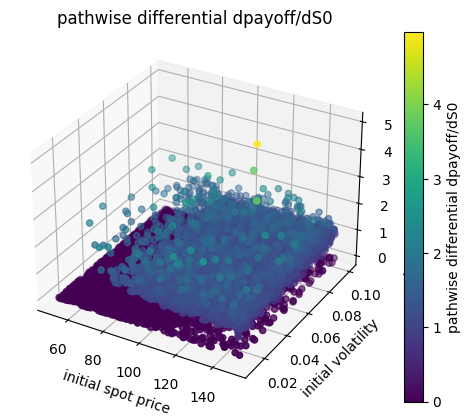

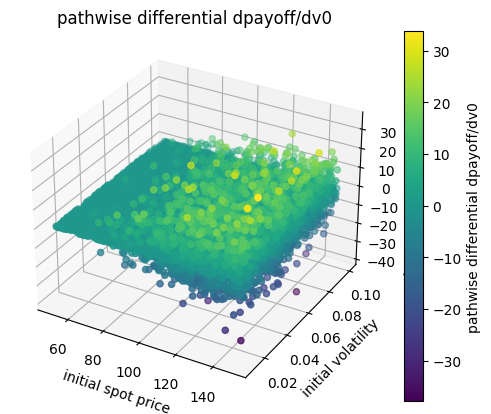

In [15]:
def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')

    print(init_spots.shape)
    print(states.S0.shape)
    # plt.plot(init_spots, states
    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
    plt.legend()
    plt.xlabel('initial spot price')
    plt.ylabel('payoff')
    # plt.ylim(-1, 1000)
    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_trisurf(hset.initial_spot_prices, hset.initial_vols, prices, linewidth=0.2)
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("initial spot price")
    ax.set_ylabel("initial volatility")
    ax.set_zlabel(label)
    return fig

print("dpayoff/dS0")
fig = plot_3d_differential_data(initial_spots, initial_vols, dps.S0, "pathwise differential dpayoff/dS0")

print("dpayoff/dv0")
fig = plot_3d_differential_data(initial_spots, initial_vols, dps.v0, "pathwise differential dpayoff/dv0")